# Wrangle and Analyze Data

by __Jamal Taghavimehr__

## Introduction

WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.
In this project, I will go through the process of data wrangling which is gathering, assessing, and cleaning and finally will derive interesting insights from the cleaned data and communicate my findings with visualizations.

## Gathering Data

### The WeRateDogs Twitter Archive

The WeRateDogs Twitter archive has been provided by the Udacity Naodegree Program. I downloaded `twitter-archive-enhanced-2.csv` file manually and imported the data in the Jupyter Notebook.

In [1]:
# import libraries needed for the wrangling project
import pandas as pd
import numpy as np
import requests as rq
import tweepy as tp
import json as js
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

In [2]:
# read csv file
twitter_archive = pd.read_csv('twitter-archive-enhanced-2.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### The Tweet Image Predictions

In this step I programatically downloaded `image_predictions.tsv` hosted on Udacity's servers using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [3]:
# Requests library of Python is used to download image predictions tweet file and write it in a .tsv file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = rq.get(url)
with open ('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [4]:
# read tsv file and show as dataframe
image_pr = pd.read_csv('image_predictions.tsv', sep = '\t')
image_pr.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Twitter API

In this step using Tweepy library and Twitter API I access twitter archive. Using the tweet IDs in the WeRateDogs Twitter archive, I query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called `tweet_json.txt`. Each tweet's JSON data should be written to its own line. Then I read this .txt file line by line into a pandas DataFrame with tweet ID, retweet count, favorite count, and display text range.

In [5]:
# http://docs.tweepy.org/en/v3.5.0/auth_tutorial.html
# register my client application with Twitter
# API keys and tokens
consumer_key = 'consumer_key'
consumer_secret = 'consumer_secret'
access_token = 'access_token'
access_secret = 'access_secret'

# creating an OAuthHandler instance
auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tp.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

I have the list of tweet ids from twitter_archive file which can be used as a list in order to fetch the actual tweets from Twitter using twitter API. The link on StackOverflow is very helpful:
https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api

In [6]:
# gather tweets from the twitter API and store them in the following list
tweets_list = []
# if tweets are not found then they are stored in the following list 
tweets_not_found = []
for ID in twitter_archive['tweet_id']:   
    try:
        tweets_list.append(api.get_status(ID))
    except Exception as e:
        tweets_not_found.append(ID)

Rate limit reached. Sleeping for: 649
Rate limit reached. Sleeping for: 655


In [7]:
# the code below is for isolation of the json part of what I gathered in tweets_list. Afterwards, I will write the list into
# a .txt file.

isolated_json_list = []
for jason_part in tweets_list:
    isolated_json_list.append(jason_part._json)

with open('tweet_json.txt', 'w') as json_file:
        json_file.write(js.dumps(isolated_json_list, indent=4))

In [6]:
# Retrieve needed information from json dictionaries and read the written .txt file line by 
# line into a pandas DataFrame with tweet ID, retweet count, favorite count, followers count, friends count, source, retweeted
# status, and url.
dict_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    needed_data = js.load(json_file)
    for dictionary in needed_data:
        tweet_id = dictionary['id'] # the id of the tweet
        favorite_count = dictionary['favorite_count'] # the number of favorites that the tweet owns
        retweet_count = dictionary['retweet_count'] # the number of retweeted counts that the tweet has
        followers_count = dictionary['user']['followers_count'] # the number of followers of the user who tweeted the tweet
        friends_count = dictionary['user']['friends_count'] # the number of friends of the user who tweeted the tweet
        source = dictionary['source'][dictionary['source'].find('rel=\"nofollow\">') +15 : -4] # what device and app has been
        # used for the tweet
        retweeted_status = dictionary['retweeted_status'] = dictionary.get('retweeted_status', 'Original tweet') # if tweet is
        # original or retwet
        only_url = dictionary['text'][dictionary['text'].find('https'):] # the web url of the tweet
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        dict_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })

In [7]:
# create the dataframe from the created dict_list
tweet_json = pd.DataFrame(dict_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])
# read the top 5 rowsof tweet_json dataframe
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,37062,7916,8395325,14,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,31894,5879,8395325,14,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,24005,3882,8395325,14,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,40386,8064,8395325,14,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,38605,8748,8395325,14,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


## Assessing Data

### Visual Assessment

#### The WeRateDogs Twitter Archive

In this section I will perform visual assessment of the gathered data from different sources. I will try to find issues about data quality including completeness, validity, accuracy, and consistency and also tidiness issues. Afterwards, I will follow the visual assessment with programatic assessment to find more quality and tidiness issues.

In [8]:
# look at the first top 5 rows of twitter_archive
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
# look at the last 5 rows of twitter_archive
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [10]:
# take  a sample of 5 rows in twitter-archive
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None
743,780459368902959104,NaN,NaN,2016-09-26 17:29:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Bear. Don't worry, he's not a real bea...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/780459368...,11,10,Bear,None,None,None,None
1181,719332531645071360,NaN,NaN,2016-04-11 01:13:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pippa. She managed to start the car bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/719332531...,11,10,Pippa,None,None,None,None
2293,667152164079423490,NaN,NaN,2015-11-19 01:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pipsy. He is a fluffball. Enjoys trave...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
112,870804317367881728,NaN,NaN,2017-06-03 00:48:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Real funny guys. Sending in a pic without a do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/870804317...,11,10,None,None,None,None,None


##### Quality issue
 - Dog name for `668955713004314625` tweet_id should be changed from a to Leroi.
 - Dog name for `805487436403003392` tweet_id should be changed from Sansa to Sansa & Gary.
 - Dog name for `748575535303884801` tweet_id should be changed from one to None.
 - Dog stage for `748575535303884801` tweet_id is pupper instead of None.
 - The urls should be cleaned from the end of text.
 - Source should be cleaned since we are only interested in the device and application such as Twitter for iPhone.
 - Dog names mistakenly entered as `a` should be removed and replaced with None or acorrect name.
 
##### Tidiness issue
 - All dog stages should be in one column instead of each forming a seperate column.
 - Ratings kind ,numerator or denominator, should be a column and the values should form another column.
 - Timestamp should be seperated in two columns of date and time.

#### List of definitions
 - __tweet_id:__ It is the unique identifier of each tweet
 - __in_reply_to_status_id:__ Whether the tweet is reply or not, if it is a reply then the original tweet ID is included
 - __in_reply_to_user_id:__ Whether the tweet is reply or not, if it is a reply then the original author's tweet ID is included
 - __timestamp:__ Time the tweet was posted
 - __source:__ what device and app has been used for the tweet
 - __text:__ The actual main text of the tweet
 - __retweeted_status_id:__ Whether the tweet is retweet or not, if it is retweet then the original tweet ID is included
 - __retweeted_status_user_id:__ If the tweet is a retweet then the author's ID of the original tweet is included
 - __retweeted_status_timestamp:__ Time the retweet is posted
 - __expanded_urls:__ The url of the tweet
 - __rating_numerator:__ The numarator of the dog's rating. Usually above 10.
 - __rating_denominator:__ The denominator of the dog's rating. It is almost always 10.
 - __name:__ What is the name of the dog is put here.
 - __doggo:__ One of the stages of dog according to dogthionary
 - __floofer:__ One of the stages of dog according to dogthionary
 - __pupper:__ One of the stages of dog according to dogthionary
 - __puppo:__ One of the stages of dog according to dogthionary

#### The Tweet Image Predictions

In [11]:
# look at the first top 5 rows of image_pr
image_pr.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
# look at the last 5 rows of image_pr
image_pr.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [13]:
# take  a sample of 5 rows in image_pr
image_pr.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
908,700505138482569216,https://pbs.twimg.com/media/Cbixs3vUUAAqHHN.jpg,1,bath_towel,0.449684,False,Norwegian_elkhound,0.160205,True,Great_Dane,0.048666,True
494,675710890956750848,https://pbs.twimg.com/media/CWCbd8ZWoAAtqoH.jpg,2,standard_schnauzer,0.441427,True,miniature_schnauzer,0.248885,True,Sealyham_terrier,0.164967,True
940,703774238772166656,https://pbs.twimg.com/media/CcRO8FmW4AAzazk.jpg,1,Labrador_retriever,0.990119,True,Chesapeake_Bay_retriever,0.008026,True,curly-coated_retriever,0.001242,True
1793,831262627380748289,https://pbs.twimg.com/media/C4k88lGVMAEKNzb.jpg,1,cocker_spaniel,0.263323,True,Brittany_spaniel,0.200550,True,doormat,0.193414,False
1458,777885040357281792,https://pbs.twimg.com/media/CsuaUH2WAAAWJh1.jpg,1,Afghan_hound,0.123529,True,basset,0.119682,True,Siberian_husky,0.108709,True


##### Quality issue
 - Dog breeds have inconsistent lower and uppercase wordings. Need to be consistent.
 
##### Tidiness issue
 - Column names are not informative. Need to replace with more inormative names.

#### List of definitions
 - __tweet_id:__ It is the unique identifier of each tweet
 - __jpg_url:__ URL of dog's picture
 - __img_num:__ Each tweet can have up to 4 images. This number of picture is relevant to the most confident prediction of the neural network method for each tweet.
 - __p1:__ p1 is the algorithm's #1 prediction for the image in the tweet
 - __p1_conf:__ p1_conf is how confident the algorithm is in its #1 prediction
 - __p1_dog:__ p1_dog is whether or not the #1 prediction is a breed of dog
 - __p2:__ p2 is the algorithm's second most likely prediction
 - __p2_conf:__ p2_conf is how confident the algorithm is in its #2 prediction
 - __p2_dog:__ p2_dog is whether or not the #2 prediction is a breed of dog
 - __p3:__ p3 is the algorithm's third most likely prediction
 - __p3_conf:__ p3_conf is how confident the algorithm is in its #3 prediction
 - __p3_dog:__ p3_dog is whether or not the #3 prediction is a breed of dog

#### Twitter API

In [14]:
# look at the first top 5 rows of tweet_json
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,37062,7916,8395325,14,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,31894,5879,8395325,14,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,24005,3882,8395325,14,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,40386,8064,8395325,14,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,38605,8748,8395325,14,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [15]:
# look at the last 5 rows of tweet_json
tweet_json.tail()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
2327,666049248165822465,101,41,8395349,14,Twitter for iPhone,Original tweet,https://t.co/4B7cOc1EDq
2328,666044226329800704,280,135,8395349,14,Twitter for iPhone,Original tweet,https://t.co/DWnyCjf2mx
2329,666033412701032449,119,43,8395349,14,Twitter for iPhone,Original tweet,https://t.co/y671yMhoiR
2330,666029285002620928,123,45,8395349,14,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI
2331,666020888022790149,2476,478,8395349,14,Twitter for iPhone,Original tweet,https://t.co/BLDqew2Ijj


In [16]:
# take  a sample of 5 rows in tweet_json
tweet_json.sample(5)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
1061,738402415918125056,3307,859,8395335,14,Twitter for iPhone,Original tweet,https://t.co/s96OYXZIfK
153,860924035999428608,0,786,8395326,14,Twitter for iPhone,This is a retweet,This is a retweet
549,802239329049477120,9469,2744,8395327,14,Twitter for iPhone,Original tweet,https://t.co/wG8NYg87Hw
521,806620845233815552,0,5819,8395328,14,Twitter for iPhone,This is a retweet,This is a retweet
1674,681231109724700672,2455,497,8395339,14,Twitter for iPhone,Original tweet,https://t.co/P16uhh1PbI


##### Quality issue
 - Everything looks good in this step.
 
##### Tidiness issue
 - Everything looks good in this step.

#### List of definitions
 - __tweet_id:__ It is the unique identifier of each tweet
 - __favorite_count:__ The number of favorites that the tweet owns
 - __retweet_count:__ The number of retweeted counts that the tweet has
 - __followers_count:__ The number of followers of the user who tweeted the tweet
 - __friends_count:__ The number of friends of the user who tweeted the tweet
 - __source:__ The device and app which has been used for the tweet
 - __retweeted_status:__ If tweet is original or retweet
 - __url:__ The web url of the tweet

### Programatic Assessment

In the programatic assessment step I will use various tools in Python to find more quality and tidiness issues.

In [17]:
# inspect the twitter_archive dataframe using info.
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

##### Quality issue
 - For consistency with other tables and better coding practice convert tweet_id dtype from integer to string.
 - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id are float and should be string.
 - Convert timestamp and retweeted_status_timestamp dtype from string to datetime.
 - Fill in the expanded_urls with null values.

##### Tidiness issue
 - Since I am looking for original tweets and not retweeted tweets or replies I will remove the records having values for retweeted_status_id and in_reply_to_status_id.
 - Consequently, columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp should be removed.

In [18]:
# show rows with missing urls in twitter_archive dataframe
twitter_archive[twitter_archive['expanded_urls'].isnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [19]:
# inspect if there are other weird names of dogs
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Lola           10
Tucker         10
Penny          10
Winston         9
Bo              9
Sadie           8
the             8
an              7
Daisy           7
Toby            7
Bailey          7
Buddy           7
Oscar           6
Dave            6
Milo            6
Bella           6
Koda            6
Stanley         6
Leo             6
Jack            6
Scout           6
Rusty           6
Jax             6
Sammy           5
             ... 
Batdog          1
Shadoe          1
Rufio           1
Brandonald      1
Sailor          1
Pluto           1
Dudley          1
Sandra          1
Tedders         1
Alfy            1
Bruiser         1
Philippe        1
Pancake         1
Tuco            1
Ito             1
Ed              1
Ozzie           1
Poppy           1
Tilly           1
Moofasa         1
Kallie          1
Ember           1
Akumi           1
Al              1
Jimbo     

In [20]:
# the number of rows with dog names of a, an, and the
len(twitter_archive.query('name == "a" or name == "an" or name == "the"'))

70

In [21]:
# show the rows with dog names of a, an, and the
twitter_archive.query('name == "a" or name == "an" or name == "the"').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
759,778396591732486144,NaN,NaN,2016-09-21 00:53:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is an East African Chalupa...,7.030419e+17,4.196984e+09,2016-02-26 02:20:37 +0000,https://twitter.com/dog_rates/status/703041949...,10,10,an,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None


##### Quality issue
 - Replace erroneous dog names of a, an, and the with a correct phrase 

In [22]:
# inspect if there are duplicated observations in Twitter_archive dataframe
twitter_archive[twitter_archive.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


##### Quality issue
 - No duplicated rows. Everything good here.

In [23]:
# see the distribution of both rating_numerator and rating_denominator
print(twitter_archive.rating_numerator.describe())
print(twitter_archive.rating_denominator.describe())

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64
count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64


In [24]:
# sort values of rating-numerator in descending order and their frequencies 
twitter_archive.rating_numerator.value_counts().sort_index(ascending=False)

1776      1
960       1
666       1
420       2
204       1
182       1
165       1
144       1
143       1
121       1
99        1
88        1
84        1
80        1
75        2
60        1
50        1
45        1
44        1
27        1
26        1
24        1
20        1
17        1
15        2
14       54
13      351
12      558
11      464
10      461
9       158
8       102
7        55
6        32
5        37
4        17
3        19
2         9
1         9
0         2
Name: rating_numerator, dtype: int64

There are some numerators that are not equal to 10 which is totally fine. The ratings below 10 should be acceptable moreover this rating system is unique and many people desire to give dogs very high ratings including 11, 12, 13, and 14. But I start become suspicious for the ratings becoming larger than 15 since it seems that a rating of 1776 out of 10 looks to be the result of error or mistake. I'd like to inspect numerators above 15.

In [25]:
# achieve the number of rating_numerator records equal and larger than 15
print(len(twitter_archive.loc[twitter_archive['rating_numerator'] >= 15]))

28


In [26]:
# sort values of rating-numerator in descending order and their frequencies 
twitter_archive.rating_denominator.value_counts().sort_index(ascending=False)

170       1
150       1
130       1
120       1
110       1
90        1
80        2
70        1
50        3
40        1
20        2
16        1
15        1
11        3
10     2333
7         1
2         1
0         1
Name: rating_denominator, dtype: int64

In [27]:
# achieve the number of rating_denominator records not equal to 10
print(len(twitter_archive.loc[twitter_archive['rating_denominator'] != 10]))

23


In [28]:
# Look at the denominators above 10
pd.set_option('display.max_colwidth', 200)
denom_sort = twitter_archive.sort_values('rating_denominator', ascending=False)
denom_sort = denom_sort[['tweet_id', 'text', 'rating_numerator', 'rating_denominator','expanded_urls']]
denom_sort.head(21)

,tweet_id,text,rating_numerator,rating_denominator,expanded_urls
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170,https://twitter.com/dog_rates/status/731156023742988288/photo/1
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150,https://twitter.com/dog_rates/status/758467244762497024/video/1
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130,"https://twitter.com/dog_rates/status/684225744407494656/photo/1,https://twitter.com/dog_rates/status/684225744407494656/photo/1"
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120,https://twitter.com/dog_rates/status/677716515794329600/photo/1
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110,https://twitter.com/dog_rates/status/684222868335505415/photo/1
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90,https://twitter.com/dog_rates/status/713900603437621249/photo/1
1843,675853064436391936,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88,80,"https://twitter.com/dog_rates/status/675853064436391936/photo/1,https://twitter.com/dog_rates/status/675853064436391936/photo/1"
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80,https://twitter.com/dog_rates/status/710658690886586372/photo/1
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1"
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50,https://twitter.com/dog_rates/status/704054845121142784/photo/1


Some denominators are surprisingly high like 170. I followed the link to the picture and noticed that the number of dogs in the picture is 17 which in total gives 17x10=170 denominator to the picture. Concurrently the sum of all points to all 17 dogs in the picture has gone up to 204. Again for 150 and other denominators higher than 10 we have the same case. In the picture with denominator of 150 there are 15 dogs. Let's look at the denominators less than 10.

In [29]:
# Look at the denominators below 10
pd.set_option('display.max_colwidth', 200)
denom_sort1 = twitter_archive.sort_values('rating_denominator', ascending=True)
denom_sort1 = denom_sort1[['tweet_id', 'text', 'rating_numerator', 'rating_denominator','expanded_urls']]
denom_sort1.head(4)

,tweet_id,text,rating_numerator,rating_denominator,expanded_urls
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0,NaN
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2,https://twitter.com/dog_rates/status/666287406224695296/photo/1
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1"
1576,687460506001633280,This is Kramer. He's a Picasso Tortellini. Tie couldn't be more accurate. Confident af. Runs his own business. 10/10 https://t.co/jIcVW0xxmH,10,10,https://twitter.com/dog_rates/status/687460506001633280/photo/1


##### Quality issue
 - Numerator/denominator rating of 9/11 for `775096608509886464` tweet_id should be changed to 14/10.
 - Numerator/denominator rating of 7/11 for `682962037429899265` tweet_id should be changed to 10/10.
 - Numerator/denominator rating of 960/0 for `835246439529840640` tweet_id should be changed to 13/10.
 - Numerator/denominator rating of 1/2 for `666287406224695296` tweet_id should be changed to 9/10.
 - Numerator/denominator rating of 24/7 for `810984652412424192` tweet_id is wrong while there is no rating or this dog. This tweet is posted for a GoFundMe for the same dog and doesn't have any rating. This observation should be removed.

In [30]:
# inspect the image_pr dataframe using info.
image_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


##### Quality issue
 - Tweet-id data type should be string instead of integer.

In [31]:
# check if there are out of range values for the level of confidence in image predictions
image_pr.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [32]:
# look at the unique values for predicted dog breeds (p1)
image_pr.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
Cardigan                      19
web_site                      19
Shetland_sheepdog             18
Eskimo_dog                    18
Maltese_dog                   18
teddy                         18
beagle                        18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
Italian_greyhound             16
kuvasz                        16
          

Obviously some predictions are not dog breeds such as dining_table. I can easily notice this via looking at the p1_dog boolean variable. After resolving the tidiness issue of this dataframe I can resolve this issue by removing rows with False value for dog breeds.

In [33]:
# inspect if there are duplicated observations in image_pr dataframe
image_pr[image_pr.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [34]:
# let's check if a specific column such as jpg_url is duplicated.
image_pr[image_pr.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [35]:
# query one of the duplicated jpg_urls.
image_pr.query('jpg_url == "https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True


In [36]:
twitter_archive.query('tweet_id == "675354435921575936" or tweet_id == "752309394570878976"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
949,752309394570878976,NaN,NaN,2016-07-11 01:11:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Everyone needs to watch this. 13/10 https://t.co/Bb3xnpsWBC,6.753544e+17,4.196984e+09,2015-12-11 16:40:19 +0000,"https://twitter.com/dog_rates/status/675354435921575936/video/1,https://twitter.com/dog_rates/status/675354435921575936/video/1",13,10,None,None,None,None,None
1865,675354435921575936,NaN,NaN,2015-12-11 16:40:19 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Everyone needs to watch this. 13/10 https://t.co/Bb3xnpsWBC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675354435921575936/video/1,13,10,None,None,None,None,None


##### Quality issue
 - There are 66 duplicated rows with different unique identifiers (tweet_id). The duplicated rows need to be removed. These are retweets.

In [37]:
# inspect the tweet_json dataframe using info.
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 8 columns):
tweet_id            2332 non-null object
favorite_count      2332 non-null int64
retweet_count       2332 non-null int64
followers_count     2332 non-null int64
friends_count       2332 non-null int64
source              2332 non-null object
retweeted_status    2332 non-null object
url                 2332 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


In [38]:
# inspect the number of retweeted tweets in twitter_archive dataframe
twitter_archive['retweeted_status_id'].isnull().value_counts()

True     2175
False     181
Name: retweeted_status_id, dtype: int64

From the result of the above code the number of Falses is the number of retweeted tweets (181) and the number of Trues is the number of original tweets (2175). Let's inspect the number of original and retweeted tweets in the Twitter API dataframe.

In [39]:
# inspect the number of retweeted tweets in Twitter API file.
tweet_json['retweeted_status'].value_counts()

Original tweet       2168
This is a retweet     164
Name: retweeted_status, dtype: int64

Both original and retweeted tweets in the API file are slightly less in numbers compared to the Twitter Archive file. This might be because of removal of tweets from Twitter on WeRateDogs account. These differences are very small and shouldn't be big issues.

In [40]:
# Need to know if there are duplicated column names amongst three dataframes
# https://stackoverflow.com/questions/53468943/collecting-duplicate-column-names-from-multiple-dataframes-python
frames = [twitter_archive, image_pr, tweet_json]
allcols = [col.columns for col in frames]
duplicated  = list(set.intersection(*map(set,allcols)))
print (duplicated)

['tweet_id']


In [41]:
# inspect the number of tweets which are in twitter archive and not in image predictios dataframe
twitter_archive[(~twitter_archive.tweet_id.isin(image_pr.tweet_id))]['tweet_id'].nunique()

281

### All issues

#### Quality issue

##### Twitter Archive
 - Dog name for `668955713004314625` tweet_id should be changed from a to Leroi.
 - Dog name for `805487436403003392` tweet_id should be changed from Sansa to Sansa & Gary.
 - Dog name for `748575535303884801` tweet_id should be changed from one to None.
 - Dog stage for `748575535303884801` tweet_id is pupper instead of None.
 - The urls should be cleaned from the end of text.
 - Source should be cleaned since we are only interested in the device and application such as Twitter for iPhone.
 - Dog names mistakenly entered as `a` should be removed and replaced with None.
 - For consistency with other tables and better coding practice convert tweet_id dtype from integer to string.
 - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id are float and should be string.
 - Convert timestamp and retweeted_status_timestamp dtype from string to datetime.
 - Fill in the expanded_urls with null values.
 - Replace erroneous dog names of `a`, `an`, `the`, and other lower case words with a None. No names are mentioned for these dogs.
 - Numerator/denominator rating of 9/11 for `775096608509886464` tweet_id should be changed to 14/10.
 - Numerator/denominator rating of 7/11 for `682962037429899265` tweet_id should be changed to 10/10.
 - Numerator/denominator rating of 960/0 for `835246439529840640` tweet_id should be changed to 13/10.
 - Numerator/denominator rating of 1/2 for `666287406224695296` tweet_id should be changed to 9/10.
 - Numerator/denominator rating of 24/7 for `810984652412424192` tweet_id is wrong while there is no rating for this dog. This tweet is posted for a GoFundMe for the same dog and doesn't have any rating. This observation should be removed.
 
##### Image Predictions
 - Dog breeds have inconsistent lower and uppercase wordings. Need to be consistent.
 - Tweet-id data type should be string instead of integer.
 - There are 66 duplicated urls with different unique identifiers (tweet_id). The duplicated rows need to be removed. These are retweets.
 
#### Tidiness issue

##### Twitter Archive
 - All dog stages should be in one column instead of each forming a seperate column.
 - Timestamp should be seperated in two columns of date and time.
 - Rating_numerator and denominator are of one kind and should be in one column. I need to unpivot them.
 - Since I am looking for original tweets and not retweeted tweets or replies I will remove the records having values for retweeted_status_id and in_reply_to_status_id.
 - Consequently, columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp should be removed.
 - Need only one column of rating which is the result of numerator divided by denominator. Drop both rating_numerator and rating_denominator columns after creating the new rating column.
 
##### Image Predictions
 - Column names are not informative. Need to replace with more inormative names. No need of the second and third predictions.

## Cleaning Data

In this section I will perform cleaning procedures on dataframes after noticing quality and tidiness issues.

In [42]:
# as common coding practice take copies of the original dataframes
archive_clean = twitter_archive.copy()
predictions_clean = image_pr.copy()
api_clean = tweet_json.copy()

__Define__
##### Twitter Archive
 - Dog name for `668955713004314625` tweet_id should be changed from a to Leroi.
 - Dog name for `805487436403003392` tweet_id should be changed from Sansa to Sansa & Gary.
 - Dog name for `748575535303884801` tweet_id should be changed from one to None.
 - Dog stage for `748575535303884801` tweet_id is pupper instead of None.

__Code__

In [43]:
# need the index of each tweet_id
print(archive_clean.query('tweet_id == "668955713004314625"').index)
print(archive_clean.query('tweet_id == "805487436403003392"').index)
print(archive_clean.query('tweet_id == "748575535303884801"').index)

Int64Index([2191], dtype='int64')
Int64Index([548], dtype='int64')
Int64Index([993], dtype='int64')


In [44]:
# change the values using at method
archive_clean.at[2191,'name']= 'Leroi'
archive_clean.at[548,'name']= 'Sansa & Gary'
archive_clean.at[993,'name']= 'None'
archive_clean.at[993,'pupper']= 'pupper'

__Test__

In [45]:
# query the corrected rows again to see if the code worked
archive_clean.query('tweet_id == "668955713004314625" or tweet_id == "805487436403003392" or tweet_id == "748575535303884801"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
548,805487436403003392,NaN,NaN,2016-12-04 19:02:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Sansa and Gary. They run along the fence together everyday, so the owners installed a window for them. Both 12/10 h*ckin romantic af https://t.co/1JUduNuaWl",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/805487436403003392/photo/1,https://twitter.com/dog_rates/status/805487436403003392/photo/1,https://twitter.com/dog_rates/status/805487436403003392/photo/1,http...",12,10,Sansa & Gary,None,None,None,None
993,748575535303884801,NaN,NaN,2016-06-30 17:54:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748575535303884801/photo/1,6,10,None,None,None,pupper,None
2191,668955713004314625,NaN,NaN,2015-11-24 00:54:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Slovakian Helter Skelter Feta named Leroi. Likes to skip on roofs. Good traction. Much balance. 10/10 wow! https://t.co/Dmy2mY2Qj5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668955713004314625/photo/1,10,10,Leroi,None,None,None,None


__Define__
##### Twitter Archive
 - The urls should be cleaned from the end of text.

__Code__

In [46]:
# slicing strings in text column and removing the slice contaning 
import re
archive_clean['text'] = archive_clean['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

__Test__

In [47]:
# look at the text column and make sure the urls are gone.
archive_clean['text']

0                                                            This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 
1       This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 
2                        This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 
3                                                                  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us 
4       This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek 
5       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek 
6                           Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjo

__Define__
##### Twitter Archive
 - Source should be cleaned since we are only interested in the device and application such as Twitter for iPhone. Unnecessary html tags should be removed.

__Code__

In [48]:
# using regex strip the html tags from the strings in source column
archive_clean['source'] = archive_clean['source'].str.replace(r'<(?:a\b[^>]*>|/a>)', '')

__Test__

In [49]:
# test to see if the code worked
archive_clean['source'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

__Define__
##### Twitter Archive
 - Dog names mistakenly entered as `a` should be removed and replaced with None. These records are not provided with dog names.

__Code__

In [50]:
# replace dog names equal to a with None
archive_clean['name']= archive_clean['name'].replace('a', 'None')

__Test__

In [51]:
# check if the code worked
archive_clean.query('name == "a"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


__Define__
##### Twitter Archive
 - For consistency with other tables and better coding practice convert tweet_id dtype from integer to string.

__Code__

In [52]:
# convert data type of tweet-id from integer to string
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

__Test__

In [53]:
# check if the code worked
archive_clean.dtypes

tweet_id                       object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

__Define__
##### Twitter Archive
 - Timestamp should be seperated in two columns of date and time and each column should be in datetime data type.

__Code__

In [54]:
# trasform data type of timestamp from object to datetime in Twitter archive dataframe
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'], errors='coerce')

In [55]:
# create new columns of date and time from timestamp
archive_clean['date'] = [d.date() for d in archive_clean['timestamp']]
archive_clean['time'] = [t.time() for t in archive_clean['timestamp']]

In [56]:
# check if the columns are created
archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,2017-08-01,16:23:56


In [57]:
# since there is no need of timestamp column, drop it
archive_clean.drop(['timestamp'], axis=1, inplace = True)

In [58]:
# get a list of columns in archive_clean
list(archive_clean.columns.values)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'date',
 'time']

In [59]:
# re-order the columns
archive_clean = archive_clean[['tweet_id',
                               'in_reply_to_status_id',
                               'in_reply_to_user_id',
                               'date',
                               'time',
                               'source',
                               'text',
                               'retweeted_status_id',
                               'retweeted_status_user_id',
                               'retweeted_status_timestamp',
                               'expanded_urls',
                               'rating_numerator',
                               'rating_denominator',
                               'name',
                               'doggo',
                               'floofer',
                               'pupper',
                               'puppo']]

In [60]:
# check the data types again
archive_clean.dtypes

tweet_id                       object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
date                           object
time                           object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [61]:
# convert date dtype from string to datetime
archive_clean['date'] = archive_clean['date'].astype('datetime64[ns]')

In [62]:
# convert time dtype from string to timestamp
archive_clean['time'] = pd.to_datetime(archive_clean['time'], format='%H:%M:%S').dt.time

__Test__

In [63]:
# check if I'm happy with the result. The time is still shown as object which doesn't mean it is string. It is time object.
# datetime dtypes works for a variable having dates.
archive_clean.dtypes

tweet_id                              object
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
date                          datetime64[ns]
time                                  object
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
dtype: object

In [64]:
# check the dataframe visually
archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,date,time,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


__Define__
##### Twitter Archive
 - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id are float and should be string.
 - Convert retweeted_status_timestamp dtype from string to datetime.

__Code__

In [65]:
# change the data types to the corrected format
archive_clean['in_reply_to_status_id'] = archive_clean['in_reply_to_status_id'].astype(str)
archive_clean['in_reply_to_user_id'] = archive_clean['in_reply_to_user_id'].astype(str)
archive_clean['retweeted_status_id'] = archive_clean['retweeted_status_id'].astype(str)
archive_clean['retweeted_status_user_id'] = archive_clean['retweeted_status_user_id'].astype(str)
archive_clean['retweeted_status_timestamp'] = pd.to_datetime(archive_clean['retweeted_status_timestamp'], errors='coerce')

__Test__

In [66]:
# check if the codes worked
archive_clean.dtypes

tweet_id                                   object
in_reply_to_status_id                      object
in_reply_to_user_id                        object
date                               datetime64[ns]
time                                       object
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object

__Define__
##### Twitter Archive
 - Fill in the expanded_urls with null values.

__Code__

In [67]:
# replace the null values of expanded-urls in archive_clean dataframe with the urls in api_clean which is more complete
archive_clean['expanded_urls'] = archive_clean['expanded_urls'].combine_first(api_clean['url'])

__Test__

In [68]:
# check if there are any null expanded_urls are left in the dataframe
archive_clean[archive_clean['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,date,time,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


__Define__
##### Twitter Archive
- Replace erroneous dog names of `a`, `an`, `the`, and other lower case words with a None. No names are mentioned for these dogs.

__Code__

In [69]:
import warnings
warnings.filterwarnings("ignore")

# using string matching replace all lower case words (not dog names) with None for dog names.
archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'

__Test__

In [70]:
# Check if any other words are left which are not names except None
archive_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Emmy',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra', 'Monkey',
       'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn', 'Boomer',
       'Cody', 'Rumble', 'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Cooper',
       'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Quinn', 'Belle', 'Zooe

__Define__
##### Twitter Archive
 - Numerator/denominator rating of 9/11 for `775096608509886464` tweet_id should be changed to 14/10.
 - Numerator/denominator rating of 7/11 for `682962037429899265` tweet_id should be changed to 10/10.
 - Numerator/denominator rating of 960/0 for `835246439529840640` tweet_id should be changed to 13/10.
 - Numerator/denominator rating of 1/2 for `666287406224695296` tweet_id should be changed to 9/10.
 - Numerator/denominator rating of 24/7 for `810984652412424192` tweet_id is wrong while there is no rating for this dog. This tweet is posted for a GoFundMe for the same dog and doesn't have any rating. This observation should be removed.

__Code__

In [71]:
# need the index of each tweet_id
print(archive_clean.query('tweet_id == "775096608509886464"').index)
print(archive_clean.query('tweet_id == "682962037429899265"').index)
print(archive_clean.query('tweet_id == "835246439529840640"').index)
print(archive_clean.query('tweet_id == "666287406224695296"').index)
print(archive_clean.query('tweet_id == "810984652412424192"').index)

Int64Index([784], dtype='int64')
Int64Index([1662], dtype='int64')
Int64Index([313], dtype='int64')
Int64Index([2335], dtype='int64')
Int64Index([516], dtype='int64')


In [72]:
# change the values using at method
archive_clean.at[784,'rating_numerator']= 14
archive_clean.at[784,'rating_denominator']= 10
archive_clean.at[1662,'rating_numerator']= 10
archive_clean.at[1662,'rating_denominator']= 10
archive_clean.at[313,'rating_numerator']= 13
archive_clean.at[313,'rating_denominator']= 10
archive_clean.at[2335,'rating_numerator']= 9
archive_clean.at[2335,'rating_denominator']= 10

In [73]:
# drop the row with wrong numerator and denominator
archive_clean.drop(archive_clean.index[516], inplace=True)

__Test__

In [74]:
# check if the row still exists
archive_clean.query('tweet_id == "810984652412424192"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,date,time,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


__Define__
##### Twitter Archive
 - All dog stages should be in one column instead of each forming a seperate column.

__Code__

In [75]:
# define a function to look into 4 columns of doggo, floofer, pupper, and puppo and bring the stage otherwise collects None.
dogs = ['doggo', 'floofer', 'pupper', 'puppo']
def define_stage(s):
    for dog_stage in s:
        if dog_stage in dogs:
            return dog_stage
        else:
            pass
    return dog_stage

In [76]:
# use .apply method to use the created define_stage function to create the new column of dog_stages and drop the other four columns
archive_clean['dog_stage'] = archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].apply(define_stage, axis = 1)
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], inplace = True, axis = 1)

__Test__

In [77]:
# test if the code worked
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2355 non-null object
in_reply_to_status_id         2355 non-null object
in_reply_to_user_id           2355 non-null object
date                          2355 non-null datetime64[ns]
time                          2355 non-null object
source                        2355 non-null object
text                          2355 non-null object
retweeted_status_id           2355 non-null object
retweeted_status_user_id      2355 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2355 non-null object
rating_numerator              2355 non-null int64
rating_denominator            2355 non-null int64
name                          2355 non-null object
dog_stage                     2355 non-null object
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(2), object(11)
memory usage: 294.4+ KB


__Define__
##### Twitter Archive
 - Since I am looking for original tweets and not retweeted tweets or replies I will remove the records having values for retweeted_status_id and in_reply_to_status_id.
 - Consequently, columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp should be removed.

__Code__

In [78]:
# keep rows with nan values for in_reply_to_status_id which include all original tweets
archive_clean = archive_clean[archive_clean['in_reply_to_status_id'] == 'nan']

In [79]:
# keep rows with nan values for retweeted_status_id which are only original tweets
archive_clean = archive_clean[archive_clean['retweeted_status_id'] == 'nan']

In [80]:
# make sure both columns only include nan
print(archive_clean.in_reply_to_status_id.value_counts())
print(archive_clean.retweeted_status_id.value_counts())

nan    2096
Name: in_reply_to_status_id, dtype: int64
nan    2096
Name: retweeted_status_id, dtype: int64


In [81]:
# drop useless columns that have no use anymore
archive_clean = archive_clean.drop(['in_reply_to_status_id',
                                    'in_reply_to_user_id',
                                    'retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis=1)

__Test__

In [82]:
# test if I'm satisfied with the results
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2096 non-null object
date                  2096 non-null datetime64[ns]
time                  2096 non-null object
source                2096 non-null object
text                  2096 non-null object
expanded_urls         2096 non-null object
rating_numerator      2096 non-null int64
rating_denominator    2096 non-null int64
name                  2096 non-null object
dog_stage             2096 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 180.1+ KB


__Define__
##### Image Predictions
 - Dog breeds have inconsistent lower and uppercase wordings. Need to be consistent.

__Code__

In [83]:
# lowercase pandas dataframe string column
predictions_clean['p1'] = predictions_clean.p1.str.lower()
predictions_clean['p2'] = predictions_clean.p2.str.lower()
predictions_clean['p3'] = predictions_clean.p3.str.lower()

__Test__

In [84]:
# test if strings in p1, p2, and p3 are lowercase
predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


__Define__
##### Image Predictions
 - Tweet-id data type should be string instead of integer.

__Code__

In [85]:
# convert data type of tweet_id from integer to string
predictions_clean['tweet_id'] = predictions_clean['tweet_id'] .astype(str)

__Test__

In [86]:
# check data type
predictions_clean.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

__Define__
##### Image Predictions
 - There are 66 duplicated jpg_urls with different unique identifiers (tweet_id). The duplicated rows need to be removed. These are retweets.

__Code__

In [87]:
# remove the duplicated jpg_urls with tweet_ids not in archive_clean that are not original tweets
condition = predictions_clean['tweet_id'].isin(archive_clean['tweet_id']) == False
predictions_clean.drop(predictions_clean[condition].index, inplace = True)

__Test__

In [88]:
# check if duplicated rows are dropped
predictions_clean[predictions_clean.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [89]:
# check more
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1970 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1970 non-null object
jpg_url     1970 non-null object
img_num     1970 non-null int64
p1          1970 non-null object
p1_conf     1970 non-null float64
p1_dog      1970 non-null bool
p2          1970 non-null object
p2_conf     1970 non-null float64
p2_dog      1970 non-null bool
p3          1970 non-null object
p3_conf     1970 non-null float64
p3_dog      1970 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 159.7+ KB


__Define__
##### Image Predictions
 - Column names are not informative. Need to replace with more inormative names. No need of the second and third predictions.

__Code__

In [90]:
# rename column names to more informative ones
predictions_clean.rename(columns={'p1': 'dog_breed_prediction',
                                  'p1_conf': 'level_of_confidence',
                                  'p1_dog': 'is_it_dog'}, inplace=True)

In [91]:
# drop useless columns not needed for analysis
predictions_clean.drop(['p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

__Test__

In [92]:
# check the dataframe
predictions_clean.head()

,tweet_id,jpg_url,img_num,dog_breed_prediction,level_of_confidence,is_it_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True


__Define__
##### Twitter Archive
 - Need only one column of rating which is the result of numerator divided by denominator. Drop both rating_numerator and rating_denominator columns after creating the new rating column.

__Code__

In [93]:
archive_clean['dog_rating'] = archive_clean['rating_numerator']/archive_clean['rating_denominator']

In [94]:
archive_clean.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace = True)

__Test__

In [95]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id         2096 non-null object
date             2096 non-null datetime64[ns]
time             2096 non-null object
source           2096 non-null object
text             2096 non-null object
expanded_urls    2096 non-null object
name             2096 non-null object
dog_stage        2096 non-null object
dog_rating       2096 non-null float64
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 163.8+ KB


## Storing Data

In this section, I will merge all 3 cleaned dataframes into a master dataframe and store it in a csv file named `twitter_archive_master`.

In [96]:
# create a master file to analyze data
twitter_archive_master = archive_clean.merge(predictions_clean, on = 'tweet_id', how = 'inner')
twitter_archive_master = twitter_archive_master.merge(api_clean, on = 'tweet_id' , how = 'inner')

In [97]:
# drop useless columns
twitter_archive_master.drop(['expanded_urls', 'source_y', 'retweeted_status'], axis=1, inplace = True)

In [98]:
# rename column names to better ones
twitter_archive_master.rename(columns={'source_x': 'application',
                                  'text': 'tweet_text',
                                  'name': 'dog_name',
                                  'level_of_confidence': 'prediction_confidence'}, inplace=True)

In [109]:
# store the master dataframe in csv file
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index = False)

## Analyzing and Visualizing Data

This is the final section where I analyze and visualize data to derive informative insights.

In [110]:
# look at the first couple of rows in dataframe
twitter_archive_master.head()

,tweet_id,date,time,application,tweet_text,dog_name,dog_stage,dog_rating,jpg_url,img_num,dog_breed_prediction,prediction_confidence,is_it_dog,favorite_count,retweet_count,followers_count,friends_count,url
0,892420643555336193,2017-08-01,16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,Phineas,None,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,37062,7916,8395325,14,https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01,00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",Tilly,None,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,True,31894,5879,8395325,14,https://t.co/aQFSeaCu9L
2,891815181378084864,2017-07-31,00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,Archie,None,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,True,24005,3882,8395325,14,https://t.co/r0YlrsGCgy
3,891689557279858688,2017-07-30,15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,Darla,None,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,40386,8064,8395325,14,https://t.co/tD36da7qLQ
4,891327558926688256,2017-07-29,16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",Franklin,None,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,38605,8748,8395325,14,https://t.co/0g0KMIVXZ3


In [111]:
# look into dataset in more detail
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 18 columns):
tweet_id                 1963 non-null object
date                     1963 non-null datetime64[ns]
time                     1963 non-null object
application              1963 non-null object
tweet_text               1963 non-null object
dog_name                 1963 non-null object
dog_stage                1963 non-null object
dog_rating               1963 non-null float64
jpg_url                  1963 non-null object
img_num                  1963 non-null int64
dog_breed_prediction     1963 non-null object
prediction_confidence    1963 non-null float64
is_it_dog                1963 non-null bool
favorite_count           1963 non-null int64
retweet_count            1963 non-null int64
followers_count          1963 non-null int64
friends_count            1963 non-null int64
url                      1963 non-null object
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), obje

In [112]:
# more information from the dataset
twitter_archive_master.describe()

,dog_rating,img_num,prediction_confidence,favorite_count,retweet_count,followers_count,friends_count
count,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1.963000e+03,1963.0
mean,1.168518,1.202241,0.593787,8517.586347,2540.638818,8.395332e+06,14.0
std,4.098603,0.559739,0.272131,12513.912043,4540.474550,5.547540e+01,0.0
min,0.000000,1.000000,0.044333,74.000000,11.000000,8.394677e+06,14.0
25%,1.000000,1.000000,0.362715,1823.500000,566.500000,8.395327e+06,14.0
50%,1.100000,1.000000,0.587342,3844.000000,1222.000000,8.395336e+06,14.0
75%,1.200000,1.000000,0.846807,10610.000000,2899.000000,8.395346e+06,14.0
max,177.600000,4.000000,1.000000,160124.000000,80052.000000,8.395349e+06,14.0


In [113]:
# look at the unique ratings and their frequencies
twitter_archive_master['dog_rating'].value_counts()

1.2      448
1.0      419
1.1      397
1.3      249
0.9      151
0.8       96
0.7       51
0.5       33
1.4       33
0.6       32
0.3       19
0.4       15
0.2       10
0.1        4
177.6      1
2.6        1
42.0       1
7.5        1
0.0        1
2.7        1
Name: dog_rating, dtype: int64

In [114]:
decimals = 1  
twitter_archive_master['dog_rating'] = twitter_archive_master['dog_rating'].apply(lambda x: round(x, decimals))

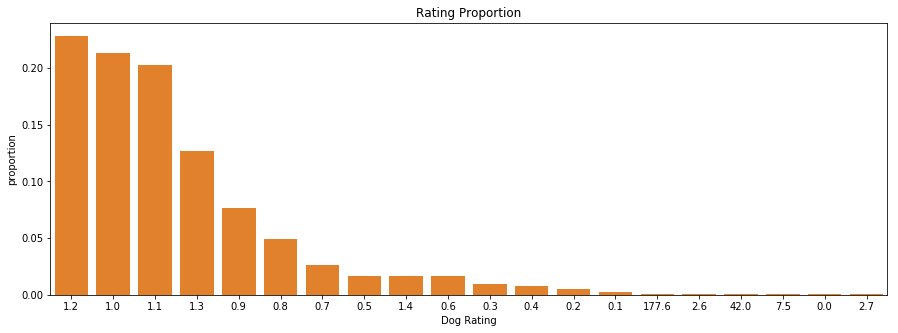

In [115]:
# bar plot for income range
plt.figure(figsize=[15,5])
n_obs = twitter_archive_master.shape[0]
max_count = twitter_archive_master['dog_rating'].value_counts().max()
max_prop = max_count / n_obs

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[1]
order = twitter_archive_master.dog_rating.value_counts().index
sb.countplot(data = twitter_archive_master, x = 'dog_rating', color = base_color, order=order)
plt.yticks(tick_props * n_obs, tick_names)
plt.ylabel('proportion')
plt.xticks(rotation= 0)
plt.title('Rating Proportion')
plt.xlabel('Dog Rating');

In [116]:
# to find the top frequent dog breeds
twitter_archive_master['dog_breed_prediction'].value_counts()[:10].index.tolist()

['golden_retriever',
 'labrador_retriever',
 'pembroke',
 'chihuahua',
 'pug',
 'chow',
 'samoyed',
 'pomeranian',
 'toy_poodle',
 'malamute']

In [117]:
# Query to obtain the top 10 most frequent dog breeds
twitter_archive_master1 = twitter_archive_master.query('dog_breed_prediction == "golden_retriever"|dog_breed_prediction == "labrador_retriever"|dog_breed_prediction == "pembroke"|dog_breed_prediction == "chihuahua"|dog_breed_prediction == "pug"|dog_breed_prediction == "chow"|dog_breed_prediction == "samoyed"|dog_breed_prediction == "pomeranian"|dog_breed_prediction == "toy_poodle"|dog_breed_prediction == "malamute"')
twitter_archive_master1['dog_breed_prediction'].value_counts()

golden_retriever      136
labrador_retriever     92
pembroke               88
chihuahua              78
pug                    54
chow                   41
samoyed                39
pomeranian             38
toy_poodle             36
malamute               29
Name: dog_breed_prediction, dtype: int64

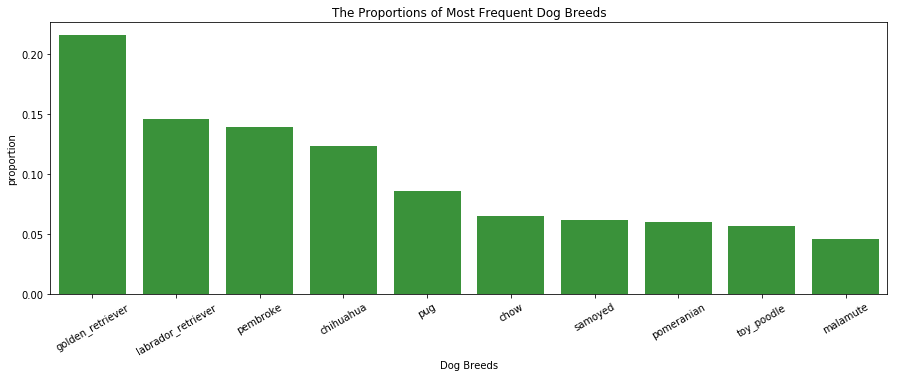

In [118]:
# bar plot for dog breeds
plt.figure(figsize=[15,5])
n_obs = twitter_archive_master1.shape[0]
max_count = twitter_archive_master1['dog_breed_prediction'].value_counts().max()
max_prop = max_count / n_obs

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, .05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[2]
order = twitter_archive_master1.dog_breed_prediction.value_counts().index
sb.countplot(data = twitter_archive_master1, x = 'dog_breed_prediction', color = base_color, order=order)
plt.yticks(tick_props * n_obs, tick_names)
plt.ylabel('proportion')
plt.xticks(rotation= 30)
plt.title('The Proportions of Most Frequent Dog Breeds')
plt.xlabel('Dog Breeds');

In [119]:
# to find the categories of dog stages
twitter_archive_master['dog_stage'].unique()

array(['None', 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

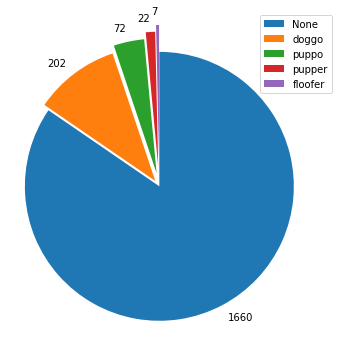

In [120]:
# Pie chart to look at the ratio of dog stages
plt.figure(figsize=[6,6])

counts = twitter_archive_master['dog_stage'].value_counts()
explode = (0, 0.05, 0.1, 0.15, 0.2)
labels = ['None', 'doggo', 'puppo', 'pupper', 'floofer']
plt.pie(counts, labels=counts, startangle = 90, explode = explode, counterclock = False)
plt.legend(labels,loc=1)
plt.axis('square');

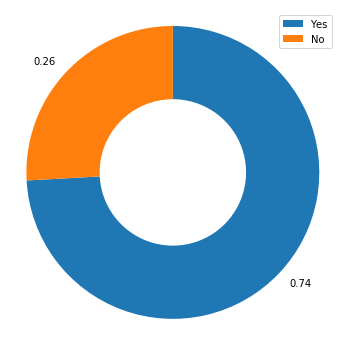

In [121]:
# donut chart to look at what ratio of predictions of neural network method are actually dog breeds
plt.figure(figsize=[6,6])

counts2 = twitter_archive_master['is_it_dog'].value_counts()
n_obs = twitter_archive_master.shape[0]
Yes = twitter_archive_master[twitter_archive_master['is_it_dog'] == True].shape[0]
No = twitter_archive_master[twitter_archive_master['is_it_dog'] == False].shape[0]
ratio = [round(Yes/n_obs,2),round(No/n_obs,2)]
labels = ['Yes', 'No']
plt.pie(counts2, labels=ratio, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.5})
plt.legend(labels,loc=1)
plt.axis('square');

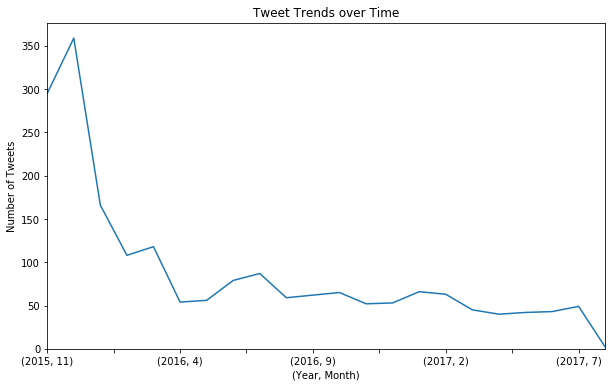

In [122]:
# trend of tweets over time
plt.figure(figsize=[10,6])
data = twitter_archive_master['tweet_id'].groupby([twitter_archive_master["date"].dt.year,
                                               twitter_archive_master["date"].dt.month]).count()
ax = data.plot('line', title='Tweet Trends over Time')
ax.set_xlabel("(Year, Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trend');

In [123]:
# take a subset of data for dog ratings below 2.
master_subset = twitter_archive_master[twitter_archive_master['dog_rating'] < 2]
master_subset = master_subset[master_subset['favorite_count'] < 40000]
master_subset = master_subset[master_subset['retweet_count'] < 20000]
master_subset.shape

(1915, 18)

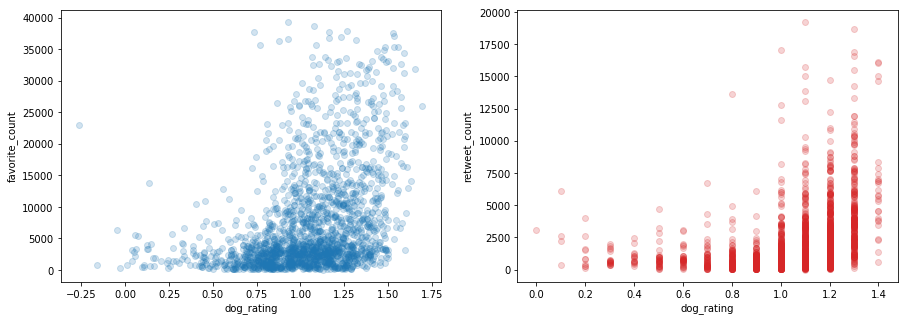

In [124]:
# Inspect the relation between dog rating vs favourite and retweet counts
plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
base_color = sb.color_palette()[0]
sb.regplot(data = master_subset, x = 'dog_rating', y = 'favorite_count', fit_reg = False,
           x_jitter = 0.3, y_jitter = 0.1, scatter_kws = {'alpha' : 1/5}, color = base_color)

plt.subplot(1,2,2)
base_color = sb.color_palette()[3]
sb.regplot(data = master_subset, x = 'dog_rating', y = 'retweet_count', fit_reg = False,
        scatter_kws = {'alpha' : 1/5}, color = base_color);

In [125]:
# Query to obtain the dog stages excluding None
twitter_archive_master2 = twitter_archive_master1.query('dog_stage == "doggo"|dog_stage == "puppo"|dog_stage == "pupper"|dog_stage == "floofer"')
twitter_archive_master2['dog_stage'].value_counts()

pupper     66
doggo      23
puppo       7
floofer     5
Name: dog_stage, dtype: int64

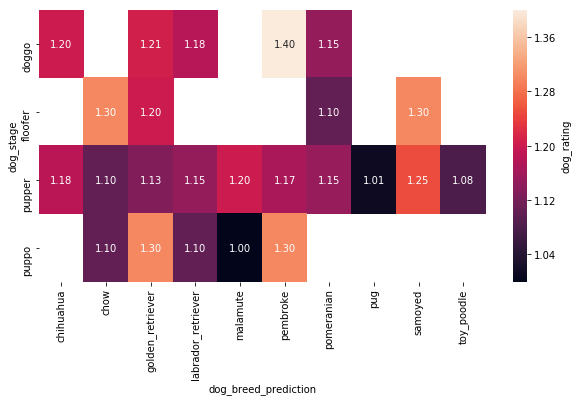

In [126]:
# darw facet grid of boxplots for variables of interest
plt.figure(figsize=[10,5])
cat = twitter_archive_master2.groupby(['dog_breed_prediction', 'dog_stage']).mean()['dog_rating']
cat = cat.reset_index(name = 'dog_rating')
cat = cat.pivot(index = 'dog_stage', columns = 'dog_breed_prediction',
                            values = 'dog_rating')
sb.heatmap(cat, annot = True, fmt = '.2f',
           cbar_kws = {'label' : 'dog_rating'});

## Conclusion

### Insight 1

The highest number of tweets has been at the end of 2015 while the total number of tweets has been reduced as of that time. It might be due the start of the twitter account while everyone was passionate about showing their dog pictures and tweeting on the twitter. The emotions have dropeped since then.

### Insight 2

The majority of dog ratings are above 1 which means that most of the dogs succeeded to achieve ratings above 100%. People love dogs and it is indeed true. Dogs are lovely creatures. Above 75% of all ratings are above 1.

### Insight 3

The most frequent dog breeds in tweets were golden and lablador retrievers. About 37% of all tweets belong to these two lovely breeds. They are also very popular in obtaining high ratings. For example, golden retrievers no matter if they are doggo, floofer, pupper, or puppo. All their average ratings are above 1.1. The most popular golden retriever is puppo. 

### Insight 4

The majority of dogs don't lie in any stage but doggo is the most frequent dog stage compared to other stages. 202 dogs are doggo in my master dataset while there are only 7 floofers.

### Insight 5

We have been successful in defining dog breeds in 74% of the tweets while 26% of predictions were not dog breeds.

### Insight 6

The number of retweets and favourites increases with the increase in dog ratings. People start retweeting and show interet in dogs with higher ratings or dogs achieve higher ratings from more retweets and favourites.

### Insight 7

The most popular breed of pupper stage is samoyed, the most popular puppo is golden retreiver and pembroke, the most popular floofer is chow and samoyed, and the most popular doggo is pembroke.